# Colab Setup  
> Make sure you configure notebook with GPU: Click Edit->notebook settings->hardware accelerator->GPU

> Uncomment the following cell after opening in Google colab. (Do not uncomment it in local setup.)  

<a target="_blank" href="https://colab.research.google.com/github/SEED-VT/FedDebug/blob/main/fault-localization/Reproduce_Figure10.ipynb"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/> </a>


In [1]:
# !pip install pytorch-lightning
# !pip install diskcache
# !pip install dotmap
# !pip install torch torchvision torchaudio
# !pip install matplotlib
# !git clone https://github.com/SEED-VT/FedDebug.git
# # appending the path
# import sys
# sys.path.append("FedDebug/fault-localization/")

# Running Code

In [2]:
import logging
import matplotlib.pyplot as plt
import time
from dotmap import DotMap
from pytorch_lightning import seed_everything
from torch.nn.init import kaiming_uniform_ 
from utils.faulty_client_localization.FaultyClientLocalization import FaultyClientLocalization
from utils.faulty_client_localization.InferenceGuidedInputs import InferenceGuidedInputs
from utils.FLSimulation import trainFLMain
from utils.fl_datasets import initializeTrainAndValidationDataset
from utils.util import aggToUpdateGlobalModel
from utils.util import testAccModel



logging.basicConfig(filename='example.log', level=logging.ERROR)
logger = logging.getLogger("pytorch_lightning")
seed_everything(786)



def evaluateFaultLocalization(predicted_faulty_clients_on_each_input, true_faulty_clients):
    true_faulty_clients = set(true_faulty_clients)
    detection_acc = 0
    for pred_faulty_clients in predicted_faulty_clients_on_each_input:
        print(f"+++ Faulty Clients {pred_faulty_clients}")
        correct_localize_faults = len(
            true_faulty_clients.intersection(pred_faulty_clients))
        acc = (correct_localize_faults/len(true_faulty_clients))*100
        detection_acc += acc
    fault_localization_acc = detection_acc / \
        len(predicted_faulty_clients_on_each_input)
    return fault_localization_acc


def runFaultyClientLocalization(client2models, exp2info, num_bugs, random_generator=kaiming_uniform_, apply_transform=True, k_gen_inputs=10, na_threshold=0.003, use_gpu=True):
    print(">  Running FaultyClientLocalization ..")
    input_shape = list(exp2info['data_config']['single_input_shape'])
    generate_inputs = InferenceGuidedInputs(client2models, input_shape, randomGenerator=random_generator, apply_transform=apply_transform,
                                            dname=exp2info['data_config']['name'], min_nclients_same_pred=5, k_gen_inputs=k_gen_inputs)
    selected_inputs, input_gen_time = generate_inputs.getInputs()

    start = time.time()
    faultyclientlocalization = FaultyClientLocalization(
        client2models, selected_inputs, use_gpu=use_gpu)

    potential_benign_clients_for_each_input = faultyclientlocalization.runFaultLocalization(
        na_threshold, num_bugs=num_bugs)
    fault_localization_time = time.time()-start
    return potential_benign_clients_for_each_input, input_gen_time, fault_localization_time





# ====== Simulation ===== 

args = DotMap()
args.lr = 0.001
args.weight_decay = 0.0001
args.batch_size = 512
args.epochs = 10  # range 10-25
args.dataset = "cifar10" # ['cifar10', 'femnist']
args.clients = 30 # keep under 30 clients and use Resnet18, Resnet34, or Densenet to evaluate on Colab 
args.faulty_clients_ids = "0,1,2,3,4" # can be multiple clients separated by comma e.g. "0,1,2"  but keep under args.clients clients and at max less than 7 
args.sampling = "iid" # [iid, "niid"] 
args.noise_rate = 1  # noise rate 0 to 1 




/home/gulzar/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 786
Global seed set to 786


### Figure 10-a, Resnet and Cifar10



  ***Simulating FL setup iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001 ***
Files already downloaded and verified
Files already downloaded and verified
Spliting Datasets 50000 into parts:[1686, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666]
input shape, torch.Size([1, 3, 32, 32])
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/faulty_client_0_noise_rate_1_classes.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Train mod batch = 150, and drop_last = False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s, loss=2.31, train_acc=0.0714, train_loss=2.310, val_acc=0.101, val_loss=2.360]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, loss=2.31, train_acc=0.0714, train_loss=2.310, val_acc=0.101, val_loss=2.360]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/faulty_client_1_noise_rate_1_classes.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.28it/s, loss=2.31, train_acc=0.102, train_loss=2.320, val_acc=0.0986, val_loss=2.390] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s, loss=2.31, train_acc=0.102, train_loss=2.320, val_acc=0.0986, val_loss=2.390]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/faulty_client_2_noise_rate_1_classes.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s, loss=2.32, train_acc=0.0705, train_loss=2.340, val_acc=0.0978, val_loss=2.530]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s, loss=2.32, train_acc=0.0705, train_loss=2.340, val_acc=0.0978, val_loss=2.530]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/faulty_client_3_noise_rate_1_classes.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s, loss=2.31, train_acc=0.0538, train_loss=2.320, val_acc=0.0853, val_loss=2.320]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s, loss=2.31, train_acc=0.0538, train_loss=2.320, val_acc=0.0853, val_loss=2.320]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/faulty_client_4_noise_rate_1_classes.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s, loss=2.31, train_acc=0.0473, train_loss=2.330, val_acc=0.0942, val_loss=2.330]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s, loss=2.31, train_acc=0.0473, train_loss=2.330, val_acc=0.0942, val_loss=2.330]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_5.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s, loss=0.63, train_acc=0.866, train_loss=0.385, val_acc=0.657, val_loss=1.630] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s, loss=0.63, train_acc=0.866, train_loss=0.385, val_acc=0.657, val_loss=1.630]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_6.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s, loss=0.697, train_acc=0.765, train_loss=0.656, val_acc=0.650, val_loss=1.620]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, loss=0.697, train_acc=0.765, train_loss=0.656, val_acc=0.650, val_loss=1.620]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_7.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s, loss=0.741, train_acc=0.780, train_loss=0.587, val_acc=0.630, val_loss=1.460]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.60it/s, loss=0.741, train_acc=0.780, train_loss=0.587, val_acc=0.630, val_loss=1.460]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_8.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s, loss=0.676, train_acc=0.827, train_loss=0.552, val_acc=0.677, val_loss=1.440]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s, loss=0.676, train_acc=0.827, train_loss=0.552, val_acc=0.677, val_loss=1.440]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_9.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s, loss=0.665, train_acc=0.786, train_loss=0.564, val_acc=0.662, val_loss=1.530]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s, loss=0.665, train_acc=0.786, train_loss=0.564, val_acc=0.662, val_loss=1.530]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_10.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.01it/s, loss=0.646, train_acc=0.728, train_loss=0.666, val_acc=0.660, val_loss=1.570]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.00it/s, loss=0.646, train_acc=0.728, train_loss=0.666, val_acc=0.660, val_loss=1.570]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_11.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s, loss=0.673, train_acc=0.831, train_loss=0.434, val_acc=0.672, val_loss=1.450]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s, loss=0.673, train_acc=0.831, train_loss=0.434, val_acc=0.672, val_loss=1.450]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_12.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s, loss=0.67, train_acc=0.841, train_loss=0.467, val_acc=0.683, val_loss=1.430] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s, loss=0.67, train_acc=0.841, train_loss=0.467, val_acc=0.683, val_loss=1.430]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_13.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.97it/s, loss=0.694, train_acc=0.825, train_loss=0.579, val_acc=0.665, val_loss=1.450]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.97it/s, loss=0.694, train_acc=0.825, train_loss=0.579, val_acc=0.665, val_loss=1.450]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_14.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s, loss=0.694, train_acc=0.768, train_loss=0.650, val_acc=0.639, val_loss=1.730]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s, loss=0.694, train_acc=0.768, train_loss=0.650, val_acc=0.639, val_loss=1.730]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_15.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s, loss=0.64, train_acc=0.790, train_loss=0.582, val_acc=0.677, val_loss=1.370] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s, loss=0.64, train_acc=0.790, train_loss=0.582, val_acc=0.677, val_loss=1.370]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_16.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.97it/s, loss=0.628, train_acc=0.830, train_loss=0.524, val_acc=0.687, val_loss=1.350]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s, loss=0.628, train_acc=0.830, train_loss=0.524, val_acc=0.687, val_loss=1.350]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_17.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.02it/s, loss=0.667, train_acc=0.880, train_loss=0.423, val_acc=0.688, val_loss=1.290]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.00it/s, loss=0.667, train_acc=0.880, train_loss=0.423, val_acc=0.688, val_loss=1.290]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_18.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s, loss=0.686, train_acc=0.741, train_loss=0.699, val_acc=0.632, val_loss=1.770]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s, loss=0.686, train_acc=0.741, train_loss=0.699, val_acc=0.632, val_loss=1.770]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_19.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s, loss=0.624, train_acc=0.827, train_loss=0.551, val_acc=0.666, val_loss=1.480]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.35it/s, loss=0.624, train_acc=0.827, train_loss=0.551, val_acc=0.666, val_loss=1.480]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_20.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s, loss=0.658, train_acc=0.773, train_loss=0.722, val_acc=0.674, val_loss=1.300]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s, loss=0.658, train_acc=0.773, train_loss=0.722, val_acc=0.674, val_loss=1.300]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_21.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, loss=0.66, train_acc=0.836, train_loss=0.513, val_acc=0.667, val_loss=1.390] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s, loss=0.66, train_acc=0.836, train_loss=0.513, val_acc=0.667, val_loss=1.390]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_22.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s, loss=0.707, train_acc=0.777, train_loss=0.640, val_acc=0.660, val_loss=1.390]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s, loss=0.707, train_acc=0.777, train_loss=0.640, val_acc=0.660, val_loss=1.390]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_23.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s, loss=0.644, train_acc=0.840, train_loss=0.517, val_acc=0.690, val_loss=1.300]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s, loss=0.644, train_acc=0.840, train_loss=0.517, val_acc=0.690, val_loss=1.300]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_24.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s, loss=0.62, train_acc=0.828, train_loss=0.417, val_acc=0.669, val_loss=1.540] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.66it/s, loss=0.62, train_acc=0.828, train_loss=0.417, val_acc=0.669, val_loss=1.540]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_25.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s, loss=0.617, train_acc=0.874, train_loss=0.369, val_acc=0.682, val_loss=1.320]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s, loss=0.617, train_acc=0.874, train_loss=0.369, val_acc=0.682, val_loss=1.320]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_26.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s, loss=0.637, train_acc=0.789, train_loss=0.598, val_acc=0.695, val_loss=1.390]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s, loss=0.637, train_acc=0.789, train_loss=0.598, val_acc=0.695, val_loss=1.390]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_27.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s, loss=0.675, train_acc=0.767, train_loss=0.718, val_acc=0.668, val_loss=1.520]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s, loss=0.675, train_acc=0.767, train_loss=0.718, val_acc=0.668, val_loss=1.520]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_28.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s, loss=0.598, train_acc=0.869, train_loss=0.412, val_acc=0.681, val_loss=1.350]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s, loss=0.598, train_acc=0.869, train_loss=0.412, val_acc=0.681, val_loss=1.350]
Training : .storage/checkpoints/iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_29.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.45it/s, loss=0.691, train_acc=0.815, train_loss=0.547, val_acc=0.642, val_loss=1.580]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.
Epoch 9: 100%|██████████| 4/4 [00:01<00:00,  2.44it/s, loss=0.691, train_acc=0.815, train_loss=0.547, val_acc=0.642, val_loss=1.580]
Total clients: 30
++Training is done: iid_resnet18_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001
>  Running FaultyClientLocalization ..
Same prediction threshold 5
>> Deubg: Simple Random inputs
+++ Faulty Clients {0, 1, 3, 4, 23}
+++ Faulty Clients {0, 1, 3, 4, 23}
+++ Faulty Clients {0, 1, 3, 4, 23}
+++ Faulty Clients {0, 1, 3, 4, 23}
+++ Faulty Clients {0, 1, 3, 4, 23}
+++ Faulty Clients {0, 1, 3, 4, 23}
+++ Faulty Clients {0, 1, 3, 4, 23}
+++ Faulty Clients {0, 1, 3, 4, 23}
+++ Faulty Clients {0, 1, 3, 4, 23}
+++ Faulty Clients {0, 1, 3, 4, 23}
#Figure 10: NA threshold: 0 Fault Localization Accuracy: 80.0, Distribution: iid,  Faulty clients: 5, Total Clients: 30, Architecture: resnet18, Dataset: cifar10
>  Running FaultyClientLocalization ..
Same prediction threshol

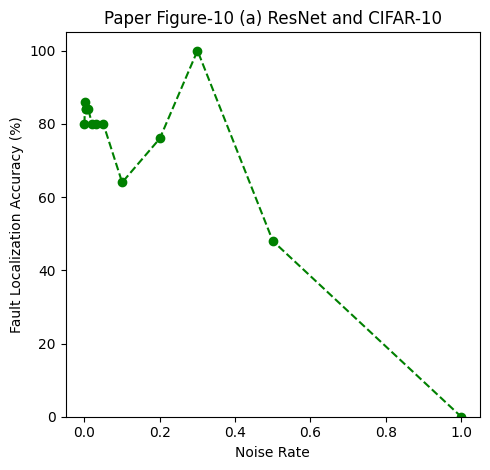

In [3]:
args.model = "resnet18" # [resnet18, resnet34, resnet50, densenet121, vgg16]
c2ms, exp2info = trainFLMain(args)
client2models = {k: v.model.eval() for k, v in c2ms.items()}


# Fault localazation
neuron_act_thresholds = [0, 0.001, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 1]

na2acc = []

for na_t in neuron_act_thresholds:
    potential_faulty_clients, _, _ = runFaultyClientLocalization(
        client2models=client2models, exp2info=exp2info, num_bugs=len(exp2info['faulty_clients_ids']), na_threshold=na_t)

    fault_acc = evaluateFaultLocalization(
        potential_faulty_clients, exp2info['faulty_clients_ids'])


    print(f"#Figure 10: NA threshold: {na_t} Fault Localization Accuracy: {fault_acc}, Distribution: {args.sampling},  Faulty clients: {len(args.faulty_clients_ids.split(','))}, Total Clients: {args.clients}, Architecture: {args.model}, Dataset: {args.dataset}")
    na2acc.append(fault_acc)



x = neuron_act_thresholds 

fig, axes = plt.subplots(1, 1) 
axes.plot(x, na2acc, 'g--o') 
# axes[1].plot(x, y2_fault_acc, 'm--o')

axes.set_xlabel('Noise Rate')
axes.set_ylabel('Fault Localization Accuracy (%)')
axes.set_title("Paper Figure-10 (a) ResNet and CIFAR-10")


axes.set_ylim(0, 105)


fig.set_figwidth(5)
plt.tight_layout()


### Figure 10-C, Densenet121 and Cifar10



  ***Simulating FL setup iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001 ***
Files already downloaded and verified
Files already downloaded and verified
Spliting Datasets 50000 into parts:[1686, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666, 1666]
input shape, torch.Size([1, 3, 32, 32])
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/faulty_client_0_noise_rate_1_classes.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 150, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, loss=2.32, train_acc=0.0771, train_loss=2.390, val_acc=0.0772, val_loss=2.540]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, loss=2.32, train_acc=0.0771, train_loss=2.390, val_acc=0.0772, val_loss=2.540]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/faulty_client_1_noise_rate_1_classes.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Train mod batch = 130, and drop_last = False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s, loss=2.33, train_acc=0.157, train_loss=2.310, val_acc=0.0595, val_loss=2.380] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s, loss=2.33, train_acc=0.157, train_loss=2.310, val_acc=0.0595, val_loss=2.380]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/faulty_client_2_noise_rate_1_classes.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, loss=2.33, train_acc=0.0966, train_loss=2.290, val_acc=0.0708, val_loss=3.390]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s, loss=2.33, train_acc=0.0966, train_loss=2.290, val_acc=0.0708, val_loss=3.390]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/faulty_client_3_noise_rate_1_classes.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.37it/s, loss=2.33, train_acc=0.0984, train_loss=2.300, val_acc=0.0937, val_loss=2.540]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.37it/s, loss=2.33, train_acc=0.0984, train_loss=2.300, val_acc=0.0937, val_loss=2.540]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/faulty_client_4_noise_rate_1_classes.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, loss=2.33, train_acc=0.136, train_loss=2.300, val_acc=0.0747, val_loss=2.760] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s, loss=2.33, train_acc=0.136, train_loss=2.300, val_acc=0.0747, val_loss=2.760]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_5.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Train mod batch = 130, and drop_last = False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s, loss=0.44, train_acc=0.916, train_loss=0.306, val_acc=0.718, val_loss=1.270] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.33it/s, loss=0.44, train_acc=0.916, train_loss=0.306, val_acc=0.718, val_loss=1.270]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_6.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Train mod batch = 130, and drop_last = False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, loss=0.453, train_acc=0.917, train_loss=0.295, val_acc=0.715, val_loss=1.290]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, loss=0.453, train_acc=0.917, train_loss=0.295, val_acc=0.715, val_loss=1.290]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_7.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s, loss=0.468, train_acc=0.909, train_loss=0.297, val_acc=0.728, val_loss=1.220]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s, loss=0.468, train_acc=0.909, train_loss=0.297, val_acc=0.728, val_loss=1.220]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_8.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s, loss=0.512, train_acc=0.890, train_loss=0.385, val_acc=0.711, val_loss=1.250]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s, loss=0.512, train_acc=0.890, train_loss=0.385, val_acc=0.711, val_loss=1.250]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_9.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Train mod batch = 130, and drop_last = False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, loss=0.467, train_acc=0.871, train_loss=0.306, val_acc=0.712, val_loss=1.260]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, loss=0.467, train_acc=0.871, train_loss=0.306, val_acc=0.712, val_loss=1.260]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_10.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s, loss=0.472, train_acc=0.860, train_loss=0.445, val_acc=0.735, val_loss=1.210]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s, loss=0.472, train_acc=0.860, train_loss=0.445, val_acc=0.735, val_loss=1.210]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_11.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s, loss=0.426, train_acc=0.922, train_loss=0.278, val_acc=0.740, val_loss=1.300]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s, loss=0.426, train_acc=0.922, train_loss=0.278, val_acc=0.740, val_loss=1.300]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_12.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Train mod batch = 130, and drop_last = False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, loss=0.47, train_acc=0.834, train_loss=0.441, val_acc=0.732, val_loss=1.140] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, loss=0.47, train_acc=0.834, train_loss=0.441, val_acc=0.732, val_loss=1.140]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_13.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s, loss=0.474, train_acc=0.878, train_loss=0.348, val_acc=0.726, val_loss=1.250]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s, loss=0.474, train_acc=0.878, train_loss=0.348, val_acc=0.726, val_loss=1.250]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_14.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, loss=0.422, train_acc=0.876, train_loss=0.316, val_acc=0.741, val_loss=1.130]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, loss=0.422, train_acc=0.876, train_loss=0.316, val_acc=0.741, val_loss=1.130]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_15.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s, loss=0.465, train_acc=0.897, train_loss=0.290, val_acc=0.732, val_loss=1.210]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s, loss=0.465, train_acc=0.897, train_loss=0.290, val_acc=0.732, val_loss=1.210]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_16.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s, loss=0.515, train_acc=0.857, train_loss=0.392, val_acc=0.690, val_loss=1.440]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s, loss=0.515, train_acc=0.857, train_loss=0.392, val_acc=0.690, val_loss=1.440]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_17.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, loss=0.478, train_acc=0.907, train_loss=0.367, val_acc=0.715, val_loss=1.300]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, loss=0.478, train_acc=0.907, train_loss=0.367, val_acc=0.715, val_loss=1.300]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_18.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, loss=0.418, train_acc=0.891, train_loss=0.272, val_acc=0.731, val_loss=1.220]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s, loss=0.418, train_acc=0.891, train_loss=0.272, val_acc=0.731, val_loss=1.220]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_19.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s, loss=0.443, train_acc=0.918, train_loss=0.273, val_acc=0.725, val_loss=1.220]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s, loss=0.443, train_acc=0.918, train_loss=0.273, val_acc=0.725, val_loss=1.220]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_20.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s, loss=0.43, train_acc=0.953, train_loss=0.223, val_acc=0.698, val_loss=1.590] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s, loss=0.43, train_acc=0.953, train_loss=0.223, val_acc=0.698, val_loss=1.590]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_21.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s, loss=0.44, train_acc=0.919, train_loss=0.242, val_acc=0.737, val_loss=1.170] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s, loss=0.44, train_acc=0.919, train_loss=0.242, val_acc=0.737, val_loss=1.170]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_22.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s, loss=0.411, train_acc=0.881, train_loss=0.269, val_acc=0.728, val_loss=1.290]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s, loss=0.411, train_acc=0.881, train_loss=0.269, val_acc=0.728, val_loss=1.290]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_23.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s, loss=0.511, train_acc=0.866, train_loss=0.423, val_acc=0.726, val_loss=1.180]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s, loss=0.511, train_acc=0.866, train_loss=0.423, val_acc=0.726, val_loss=1.180]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_24.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s, loss=0.472, train_acc=0.900, train_loss=0.371, val_acc=0.710, val_loss=1.290]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s, loss=0.472, train_acc=0.900, train_loss=0.371, val_acc=0.710, val_loss=1.290]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_25.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s, loss=0.44, train_acc=0.886, train_loss=0.311, val_acc=0.719, val_loss=1.250] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s, loss=0.44, train_acc=0.886, train_loss=0.311, val_acc=0.719, val_loss=1.250]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_26.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s, loss=0.43, train_acc=0.887, train_loss=0.314, val_acc=0.724, val_loss=1.300] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s, loss=0.43, train_acc=0.887, train_loss=0.314, val_acc=0.724, val_loss=1.300]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_27.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s, loss=0.517, train_acc=0.882, train_loss=0.313, val_acc=0.701, val_loss=1.280]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s, loss=0.517, train_acc=0.882, train_loss=0.313, val_acc=0.701, val_loss=1.280]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_28.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 130, and drop_last = False
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s, loss=0.436, train_acc=0.875, train_loss=0.360, val_acc=0.723, val_loss=1.220]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s, loss=0.436, train_acc=0.875, train_loss=0.360, val_acc=0.723, val_loss=1.220]
Training : .storage/checkpoints/iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001/client_29.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Train mod batch = 130, and drop_last = False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s, loss=0.397, train_acc=0.946, train_loss=0.177, val_acc=0.744, val_loss=1.220]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.
Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s, loss=0.397, train_acc=0.946, train_loss=0.177, val_acc=0.744, val_loss=1.220]
Total clients: 30
++Training is done: iid_densenet121_cifar10_clients_30_faulty_[0, 1, 2, 3, 4]_bsize_512_epochs_10_lr_0.001
>  Running FaultyClientLocalization ..
Same prediction threshold 5
>> Deubg: Simple Random inputs
+++ Faulty Clients {0, 1, 2, 3, 4}
+++ Faulty Clients {0, 1, 2, 3, 4}
+++ Faulty Clients {0, 1, 2, 3, 4}
+++ Faulty Clients {0, 1, 2, 3, 4}
+++ Faulty Clients {0, 1, 2, 3, 4}
+++ Faulty Clients {0, 1, 2, 3, 4}
+++ Faulty Clients {0, 1, 2, 3, 4}
+++ Faulty Clients {0, 1, 2, 3, 4}
+++ Faulty Clients {0, 1, 2, 3, 4}
+++ Faulty Clients {0, 1, 2, 3, 4}
#Figure 10: NA threshold: 0 Fault Localization Accuracy: 100.0, Distribution: iid,  Faulty clients: 5, Total Clients: 30, Architecture: densenet121, Dataset: cifar10
>  Running FaultyClientLocalization ..
Same prediction threshold 5

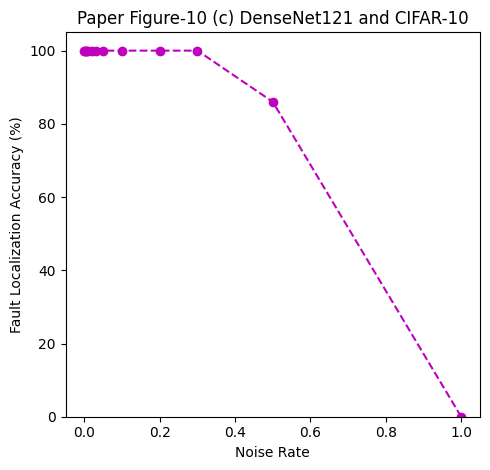

In [4]:

args.model = "densenet121" # [resnet18, resnet34, resnet50, densenet121, vgg16]
c2ms, exp2info = trainFLMain(args)
client2models = {k: v.model.eval() for k, v in c2ms.items()}


# Fault localazation
neuron_act_thresholds = [0, 0.001, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 1]

na2acc = []

for na_t in neuron_act_thresholds:
    potential_faulty_clients, _, _ = runFaultyClientLocalization(
        client2models=client2models, exp2info=exp2info, num_bugs=len(exp2info['faulty_clients_ids']), na_threshold=na_t)

    fault_acc = evaluateFaultLocalization(
        potential_faulty_clients, exp2info['faulty_clients_ids'])


    print(f"#Figure 10: NA threshold: {na_t} Fault Localization Accuracy: {fault_acc}, Distribution: {args.sampling},  Faulty clients: {len(args.faulty_clients_ids.split(','))}, Total Clients: {args.clients}, Architecture: {args.model}, Dataset: {args.dataset}")
    na2acc.append(fault_acc)



x = neuron_act_thresholds 

fig, axes = plt.subplots(1, 1) 
axes.plot(x, na2acc, 'm--o') 
# axes[1].plot(x, y2_fault_acc, 'm--o')

axes.set_xlabel('Noise Rate')
axes.set_ylabel('Fault Localization Accuracy (%)')
axes.set_title("Paper Figure-10 (c) DenseNet121 and CIFAR-10")


axes.set_ylim(0, 105)


fig.set_figwidth(5)
plt.tight_layout()


